In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import sys

### Optical Flow
$$\min_\mathbf{d} E(\mathbf{d}) = \|\mathbf{J}(\mathbf{x}+\mathbf{d})-\mathbf{I}(\mathbf{x})\|^2$$

Three steps for solving this minimization problem:

- Solve for $\frac{\delta E}{\delta \mathbf{d}}|_{\mathbf{d^*}}=0$

\begin{align}
\frac{\delta E}{\delta \mathbf{d}}\bigg|_{\mathbf{d^*}} &= 2\frac{\delta \mathbf{J(x+d)}^\top}{\delta \mathbf{d}}(\mathbf{J}(\mathbf{x}+\mathbf{d})-\mathbf{I}(\mathbf{x})) = 0 \\
\frac{\delta E}{\delta \mathbf{d}}\bigg|_{\mathbf{d^*}} &= 2\frac{\delta \mathbf{J(x)}^\top}{\delta \mathbf{x}}(\mathbf{J}(\mathbf{x}+\mathbf{d})-\mathbf{I}(\mathbf{x})) = 0
\end{align}
where $\frac{\delta \mathbf{J}}{\delta \mathbf{x}} = \left[\begin{array}{cc}\frac{\delta \mathbf{J}}{\delta x}&\frac{\delta \mathbf{J}}{\delta y}\end{array}\right]^\top$.
- Taylor expansion on $\mathbf{J}(\mathbf{x}+\mathbf{d})=\mathbf{J}(\mathbf{x})+\frac{\delta \mathbf{J}(\mathbf{x})}{\delta \mathbf{x}}\mathbf{d}$,

- Solve for $\mathbf{d}$, warp image, iterate

In [2]:
num_frames = 166
video_imgs = []
readdir = 'D:/44754/Documents/robotics/Perception/RoboticsPerceptionWeek3Code/data/apriltagims/image{:03d}.jpg'
for i in range(num_frames):
    tmp = cv2.imread(readdir.format(i+1))
    video_imgs.append(tmp)
video_imgs = np.array(video_imgs)
print(video_imgs.shape)

(166, 480, 640, 3)


In [3]:
initial_points = 100 * np.array([
   [1.981631469726562,3.165294189453125],
   [3.786268920898438,3.424402770996094],
   [4.036800842285157,1.686005859375000],
   [2.333528289794922,1.491907043457031] ]);

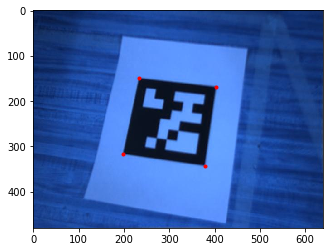

In [4]:
plt.imshow(video_imgs[0,:,:,:])
plt.plot(initial_points[:,0],initial_points[:,1],'r.')

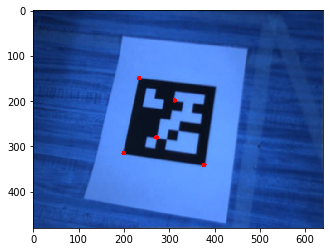

In [5]:
gray = cv2.cvtColor(video_imgs[0,:,:,:],cv2.COLOR_BGR2GRAY)
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 5,
                       qualityLevel = .1,
                       minDistance = 75,
                       blockSize = 3 )

corners = cv2.goodFeaturesToTrack(gray, mask = None, **feature_params)
# cv2.goodFeaturesToTrack(gray,30,0.01,10)
corners = np.int0(corners)
newcopy = video_imgs[0,:,:,:].copy()

for i in corners:
    x,y = i.ravel()
    cv2.circle(newcopy,(x,y),5,255,-1)

plt.imshow(newcopy)

<IPython.core.display.Javascript object>


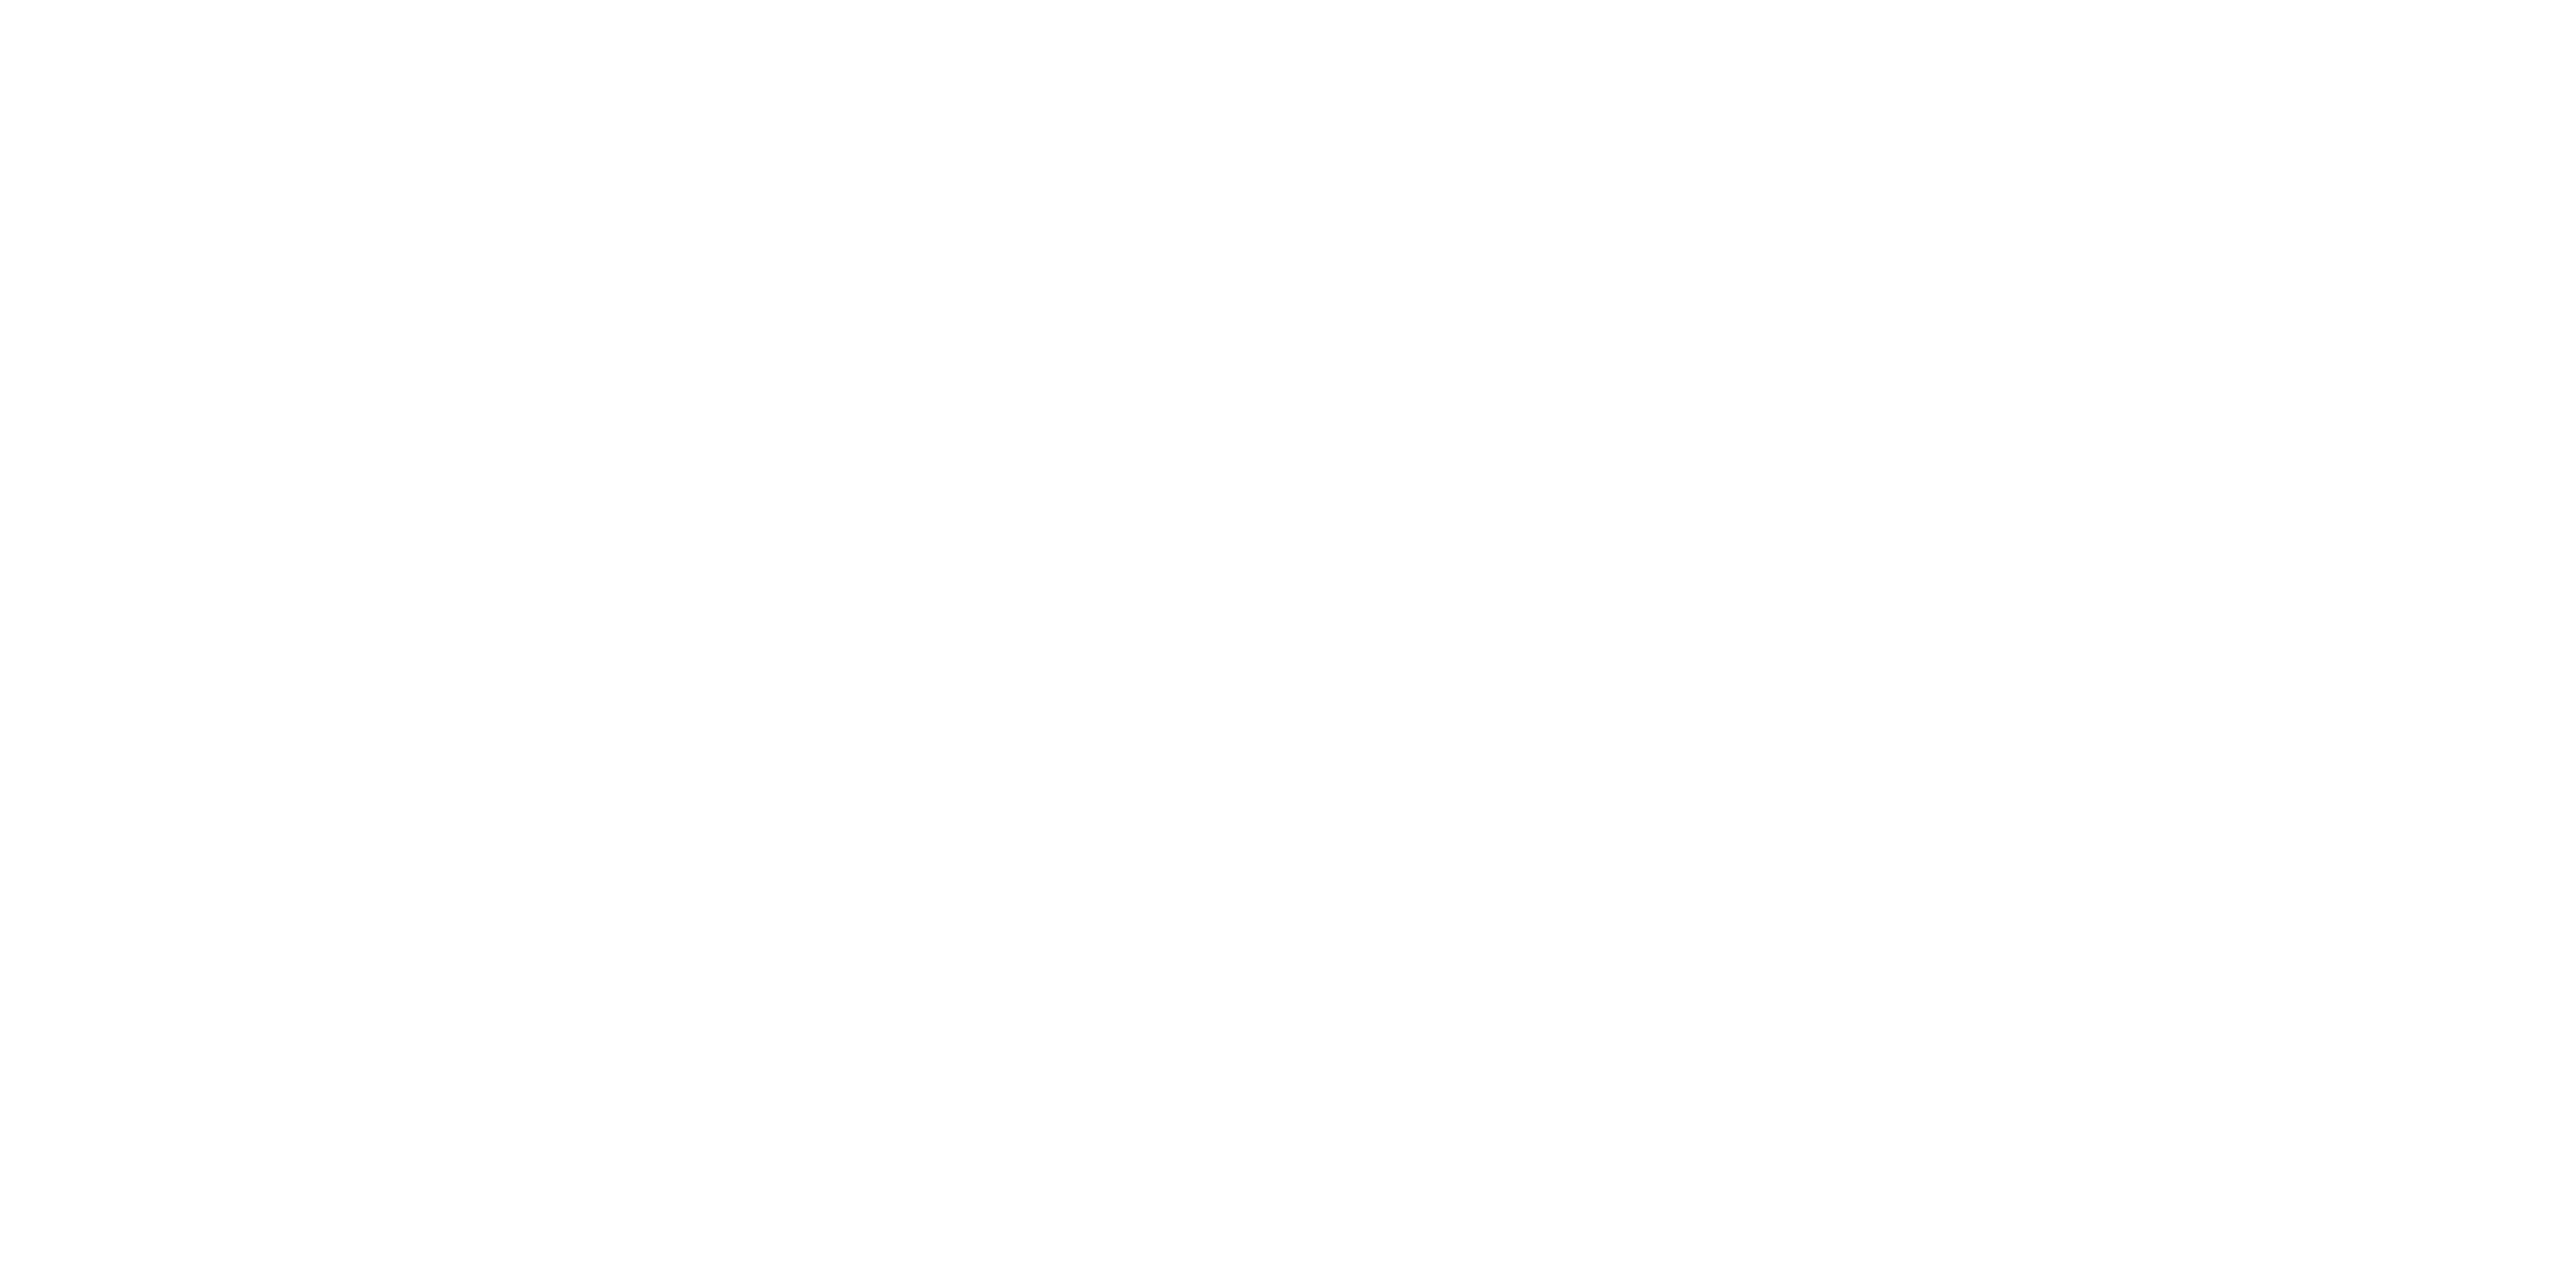

<IPython.core.display.Javascript object>


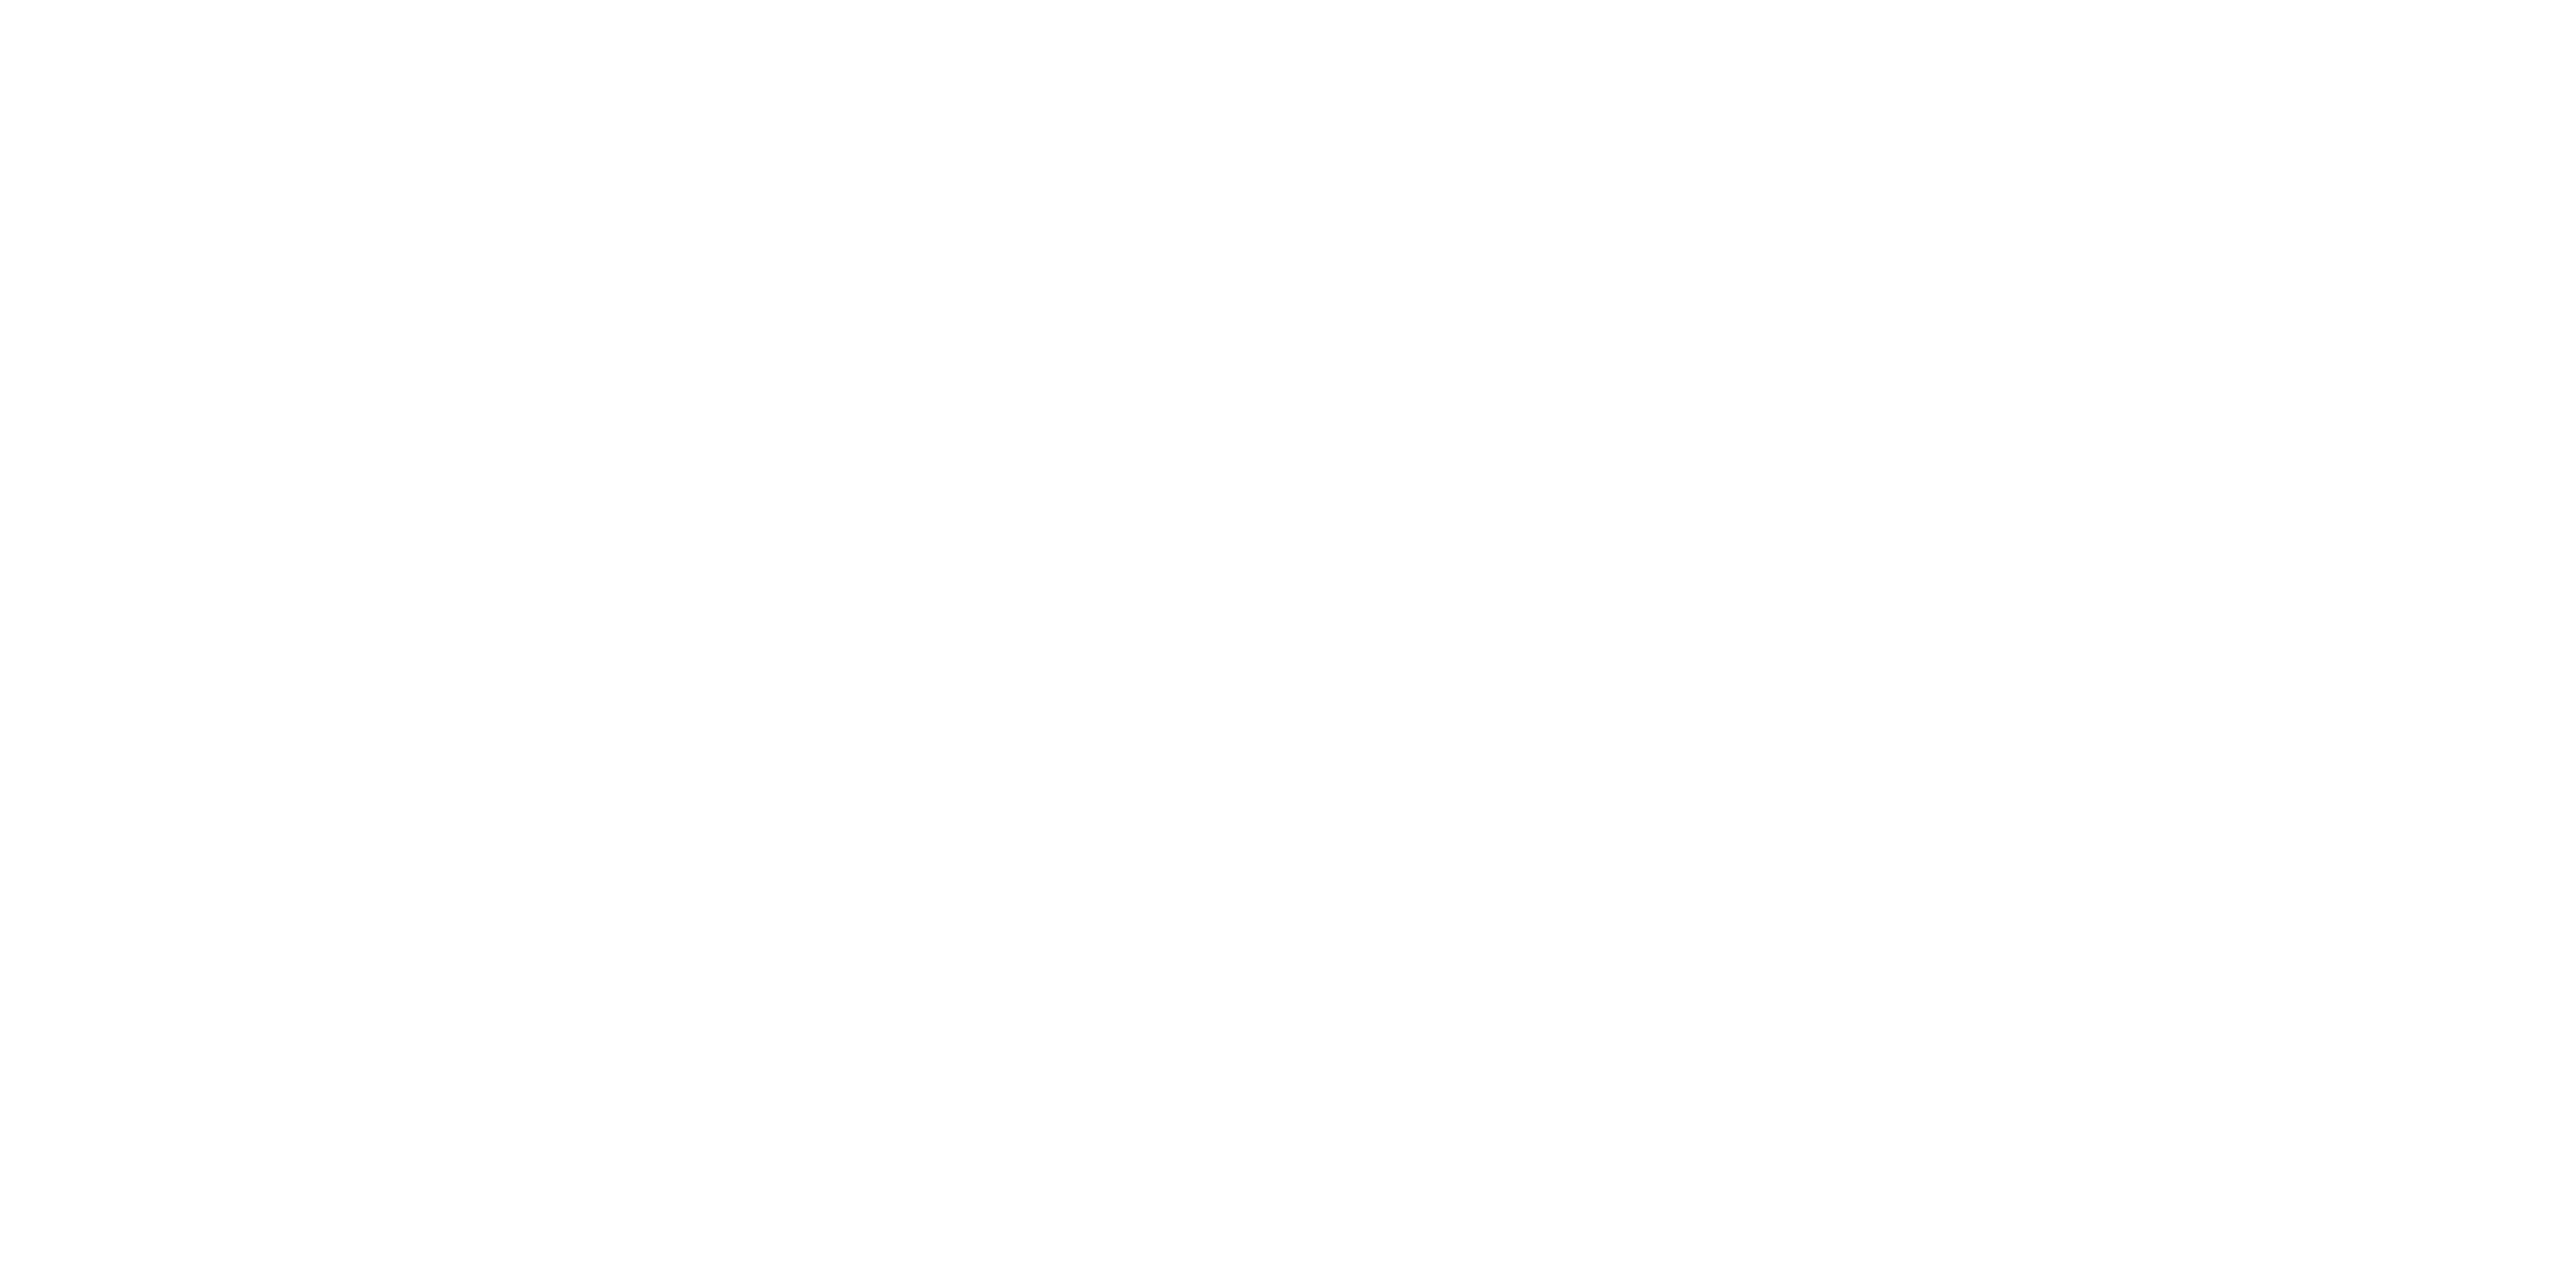

In [6]:
import cv2 as cv
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.ion()
fig.show()
fig.canvas.draw()

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (31,31),
                  maxLevel = 3,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 5, 0.03))
# Create some random colors
color = np.random.randint(0,255,(4,3))
# Take first frame and find corners in it
old_frame = video_imgs[0,:,:,:]
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = np.floor(initial_points).reshape(-1,1,2).astype(np.float32)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
for i in range(1,num_frames):
    frame = video_imgs[i,:,:,:]
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv.add(frame,mask)
    
    ax.clear()
    ax.imshow(img)
    fig.canvas.draw()
    
    k = cv.waitKey(5) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    
#     if i == num_frames-1:
    plt.savefig('result.png')